In [1]:
!pip install tensorflow opencv-python numpy matplotlib

#Import dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout , Layer, Conv2D, Dense, MaxPooling2D, Input
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Collect Data

##Labeled Faces in the Wild Dataset

In [3]:
#https://drive.google.com/file/d/19WpZ9k8Snfc5aI7I8Hrm8dzDPg7ZQcGm/view?usp=sharing
!gdown 19WpZ9k8Snfc5aI7I8Hrm8dzDPg7ZQcGm

Downloading...
From (original): https://drive.google.com/uc?id=19WpZ9k8Snfc5aI7I8Hrm8dzDPg7ZQcGm
From (redirected): https://drive.google.com/uc?id=19WpZ9k8Snfc5aI7I8Hrm8dzDPg7ZQcGm&confirm=t&uuid=4fd03e9b-eaea-4c70-b060-6a7f300c17da
To: /content/LWF.zip
100% 118M/118M [00:04<00:00, 24.3MB/s]


In [4]:
# Uncompress Labelled Faces in the Wild Dataset
!unzip LWF.zip -d LWF

Streaming output truncated to the last 5000 lines.
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: LWF/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: LWF/lfw-deepfunneled/lfw

In [5]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
dataset_path = './LWF'
files = os.listdir(dataset_path)
files

['mismatchpairsDevTest.csv',
 'pairs.csv',
 'lfw-deepfunneled',
 'matchpairsDevTest.csv',
 'peopleDevTrain.csv',
 'people.csv',
 'mismatchpairsDevTrain.csv',
 'lfw_allnames.csv',
 'matchpairsDevTrain.csv',
 'peopleDevTest.csv',
 'lfw_readme.csv']

In [7]:
# Getting the path to images dir
images_path = os.path.join(dataset_path, 'lfw-deepfunneled', 'lfw-deepfunneled')

#Listing all subdirectories (each containing images of a person)
people_dir = os.listdir(images_path)

In [8]:
#Getting the properties of images
example_dir = random.choice(people_dir)
example_images = os.listdir(os.path.join(images_path,example_dir))

sample = example_images[0]

img = Image.open(os.path.join(images_path,example_dir,sample))
print("Image name: " , sample)
print("Image shape: ", img.size)
print("Image format: ", img.format)

Image name:  Mukesh_Ambani_0003.jpg
Image shape:  (250, 250)
Image format:  JPEG


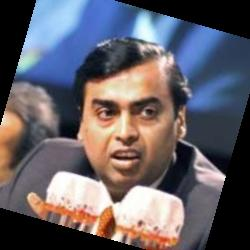

In [9]:
#Plotting example image
Image.open(os.path.join(images_path,example_dir,sample))

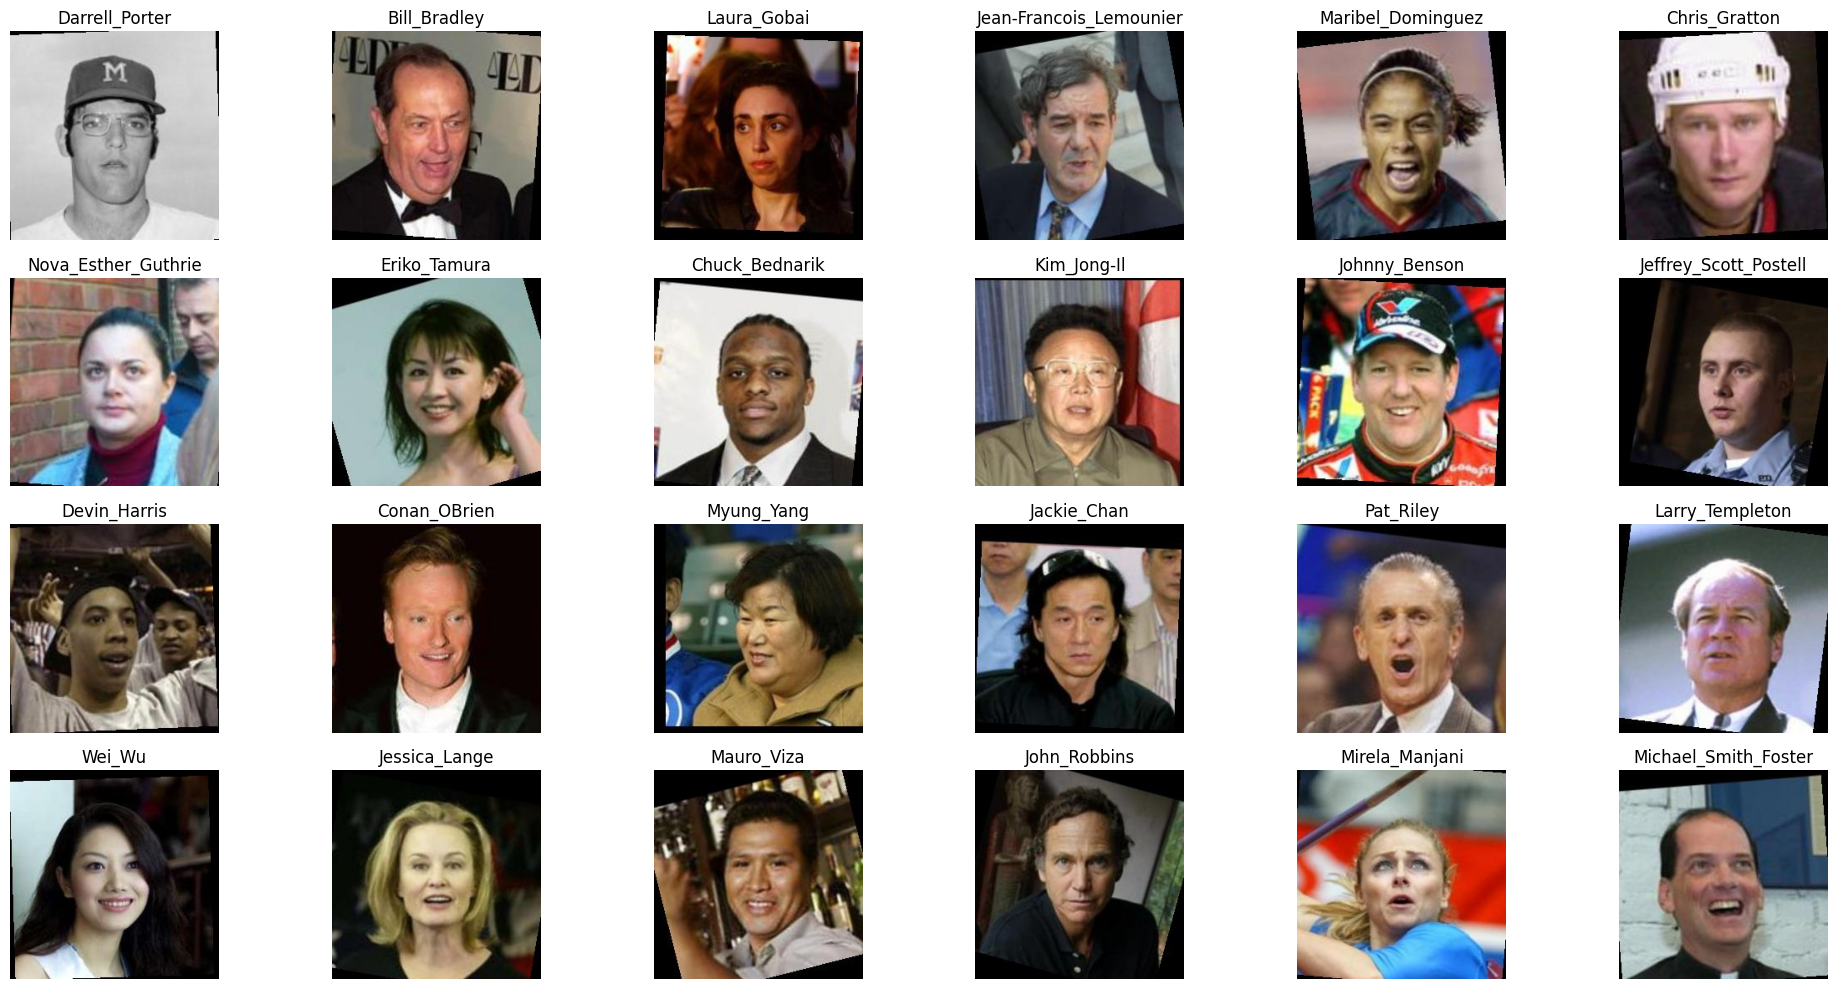

In [10]:
#Plotting more images
people_sample = np.random.choice(people_dir,24,replace=False)
sample_images_dir = []
for person in people_sample:
  person_img_dir = os.path.join(images_path,person)
  person_img_files = os.listdir(person_img_dir)
  person_example = random.choice(person_img_files)
  sample_images_dir.append(os.path.join(person_img_dir,person_example))
fig, axs = plt.subplots(4, 6, figsize=(20,10))
for i , img_path in enumerate(sample_images_dir):
  img = mpimg.imread(img_path)
  axs[i // 6 , i % 6].imshow(img)
  axs[i // 6 , i % 6].set_title(sample_images_dir[i].split('/')[-2])
  axs[i // 6 , i % 6].axis('off')
plt.tight_layout()
plt.show()

In [11]:
names_df = pd.read_csv(os.path.join(dataset_path,'lfw_allnames.csv'))
names_df.head(10)

name  images
0          AJ_Cook       1
1         AJ_Lamas       1
2    Aaron_Eckhart       1
3      Aaron_Guiel       1
4  Aaron_Patterson       1
5    Aaron_Peirsol       4
6       Aaron_Pena       1
7     Aaron_Sorkin       2
8     Aaron_Tippin       1
9        Abba_Eban       1

In [12]:
print("Number of different people in dataset: ", len(names_df))

Number of different people in dataset:  5749


Text(0.5, 0, 'Number of Images')

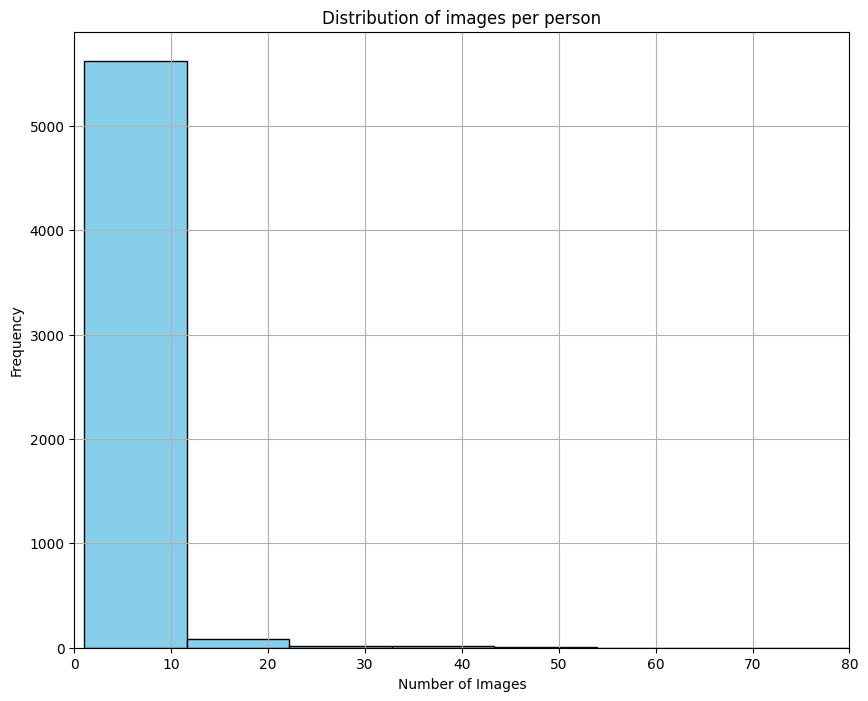

In [13]:
#Plotting the distribution of images per person'
plt.figure(figsize=(10,8))
plt.hist(names_df['images'],bins = 50, color = 'skyblue' ,edgecolor='black')
plt.title("Distribution of images per person")
plt.grid(True)
ax = plt.gca()
ax.set_xlim([0, 80])
plt.ylabel("Frequency")
plt.xlabel('Number of Images')

In [14]:
names_df.describe().T

count      mean      std  min  25%  50%  75%    max
images  5749.0  2.301792  9.01641  1.0  1.0  1.0  2.0  530.0

The highest number of images for a person is 530

In [15]:
names_df[names_df['images'] == 530]

name  images
1871  George_W_Bush     530

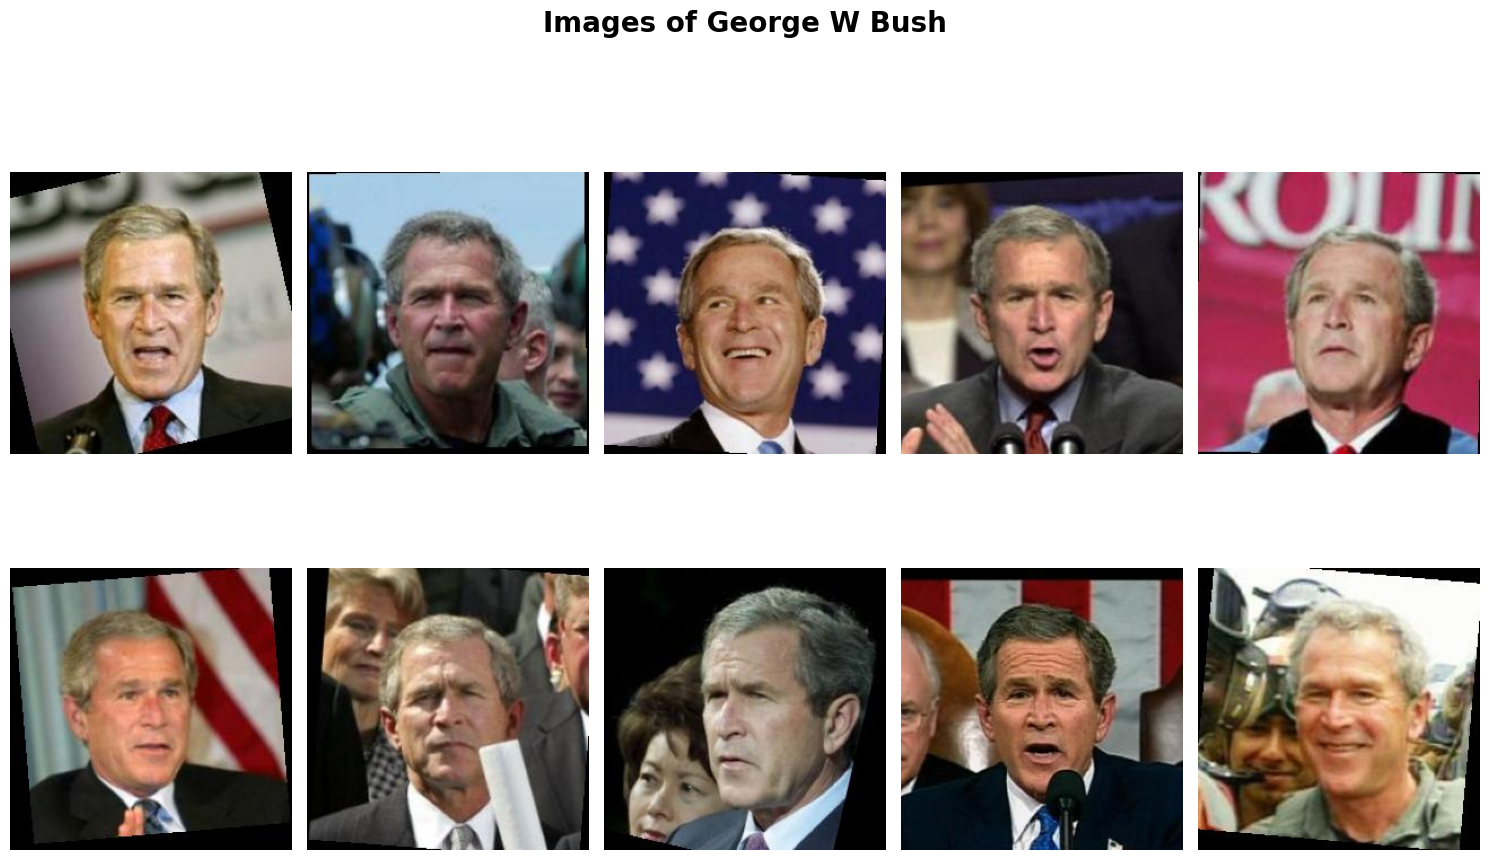

In [16]:
GWB_images = os.listdir(os.path.join(images_path,'George_W_Bush'))
sample = GWB_images[:10]
#Plotting images of George W Bush (the person with most images)
people_sample = np.random.choice(people_dir,24,replace=False)
fig, axs = plt.subplots(2, 5, figsize=(15,10))

for i , img_name in enumerate(sample):
  img_path = os.path.join(os.path.join(images_path,'George_W_Bush',img_name))
  img = mpimg.imread(img_path)
  axs[i // 5 , i % 5].imshow(img)
  axs[i // 5 , i % 5].axis('off')
fig.suptitle("Images of George W Bush",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
pairs_df = pd.read_csv(os.path.join(dataset_path,'pairs.csv'))
pairs_df.head(10)

name  imagenum1 imagenum2  Unnamed: 3
0           Abel_Pacheco          1         4         NaN
1         Akhmed_Zakayev          1         3         NaN
2         Akhmed_Zakayev          2         3         NaN
3          Amber_Tamblyn          1         2         NaN
4  Anders_Fogh_Rasmussen          1         3         NaN
5  Anders_Fogh_Rasmussen          1         4         NaN
6         Angela_Bassett          1         5         NaN
7         Angela_Bassett          2         5         NaN
8         Angela_Bassett          3         4         NaN
9            Ann_Veneman          3         5         NaN

In [18]:
pairs_df.describe()

imagenum1  Unnamed: 3
count  6000.000000  3000.00000
mean      2.421500     1.52900
std       6.473187     2.67299
min       1.000000     1.00000
25%       1.000000     1.00000
50%       1.000000     1.00000
75%       2.000000     1.00000
max     203.000000    64.00000

In [19]:
matchTrain_df = pd.read_csv(os.path.join(dataset_path,'matchpairsDevTrain.csv'))
mismatchTrain_df = pd.read_csv(os.path.join(dataset_path,'mismatchpairsDevTrain.csv'))
matchTest_df = pd.read_csv(os.path.join(dataset_path,'matchpairsDevTest.csv'))
mismatchTest_df = pd.read_csv(os.path.join(dataset_path,'mismatchpairsDevTest.csv'))

In [20]:
matchTrain_df.describe()

imagenum1    imagenum2
count  1100.000000  1100.000000
mean      2.532727     5.484545
std       5.340952    11.759833
min       1.000000     2.000000
25%       1.000000     2.000000
50%       1.000000     3.000000
75%       2.000000     5.000000
max     120.000000   212.000000

In [21]:
matchTrain_df.head(10)

name  imagenum1  imagenum2
0        Aaron_Peirsol          1          2
1        Aaron_Peirsol          3          4
2         Aaron_Sorkin          1          2
3  Abdel_Nasser_Assidi          1          2
4             Abdullah          1          3
5             Abdullah          2          4
6  Abdullah_al-Attiyah          1          3
7  Abdullah_al-Attiyah          2          3
8         Abel_Pacheco          1          4
9         Abel_Pacheco          3          4

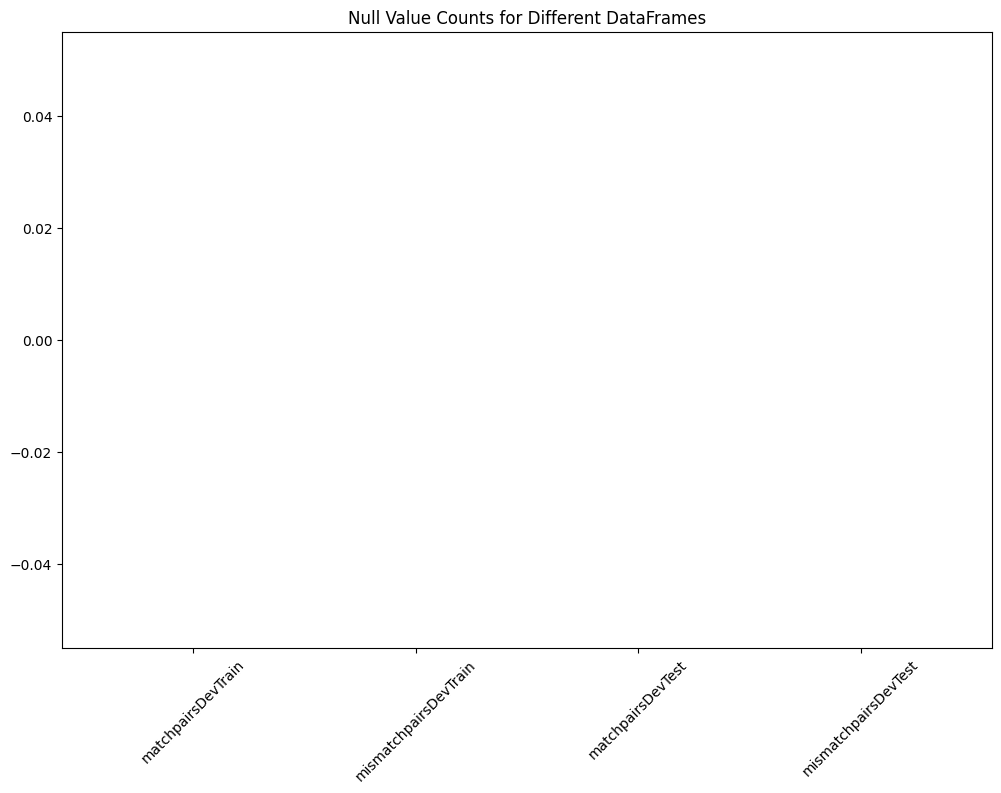

In [22]:
# Missing values check by visualization
plt.figure(figsize=(12,8))
plt.bar('matchpairsDevTrain',matchTrain_df.isnull().sum())
plt.bar('mismatchpairsDevTrain',mismatchTrain_df.isnull().sum())
plt.bar('matchpairsDevTest',matchTest_df.isnull().sum())
plt.bar('mismatchpairsDevTest',mismatchTest_df.isnull().sum())
plt.xticks(rotation=45)
plt.title('Null Value Counts for Different DataFrames')
plt.show()

There are no NAs to be handled in these dataframe, we can move on to prepare the data

##Preparing data

In [23]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.cast(img,tf.float32)
  img = tf.image.resize(img,(105,105))
  img = img / 255.0
  return img

In [24]:
img = preprocess((os.path.join(images_path,'George_W_Bush',sample[0])))

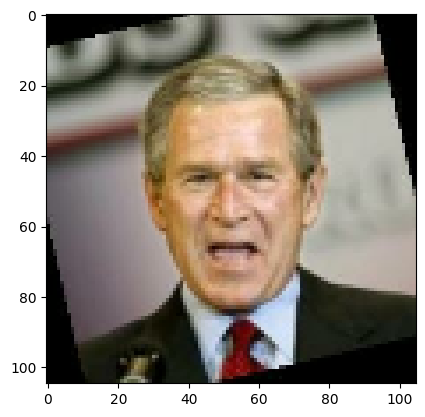

In [25]:
plt.imshow(img)

In [26]:
def create_pairs(df,is_match):
  pairs = []
  labels = []
  for _ , row in df.iterrows():
    name_1 = row['name']
    imagenum1 = row['imagenum1']
    if is_match:
      name_2 = name_1
      imagenum2 = row['imagenum2']
      label=1
    else:
      name_2 = row['name.1'] if 'name.1' in df.columns else row['name']
      imagenum2 = row['imagenum2']
      label = 0
    img1_path= os.path.join(images_path,name_1,f'{name_1}_{imagenum1:04d}.jpg')
    img2_path= os.path.join(images_path,name_2,f'{name_2}_{imagenum2:04d}.jpg')
    img1 = preprocess(img1_path)
    img2 = preprocess(img2_path)
    pairs.append([img1, img2])
    labels.append(label)
  pairs = tf.cast(pairs,tf.float32)
  labels = tf.cast(labels,tf.float32)
  return pairs, labels

In [27]:
train_matched_pairs, train_matched_labels = create_pairs(matchTrain_df, is_match=True)
train_mismatched_pairs, train_mismatched_labels = create_pairs(mismatchTrain_df, is_match=False)
test_matched_pairs, test_matched_labels = create_pairs(matchTest_df, is_match=True)
test_mismatched_pairs, test_mismatched_labels = create_pairs(mismatchTest_df, is_match=False)
#train data
train_pairs = tf.concat((train_matched_pairs,train_mismatched_pairs),axis=0)
train_label = tf.concat((train_matched_labels,train_mismatched_labels),axis=0)
#test data
test_pairs = tf.concat((test_matched_pairs,test_mismatched_pairs),axis=0)
test_label = tf.concat((test_matched_labels,test_mismatched_labels),axis=0)

In [28]:
print(type(train_pairs))
print(train_pairs.shape)
(train_pairs[0][0]).shape

<class 'tensorflow.python.framework.ops.EagerTensor'>
(2200, 2, 105, 105, 3)


TensorShape([105, 105, 3])

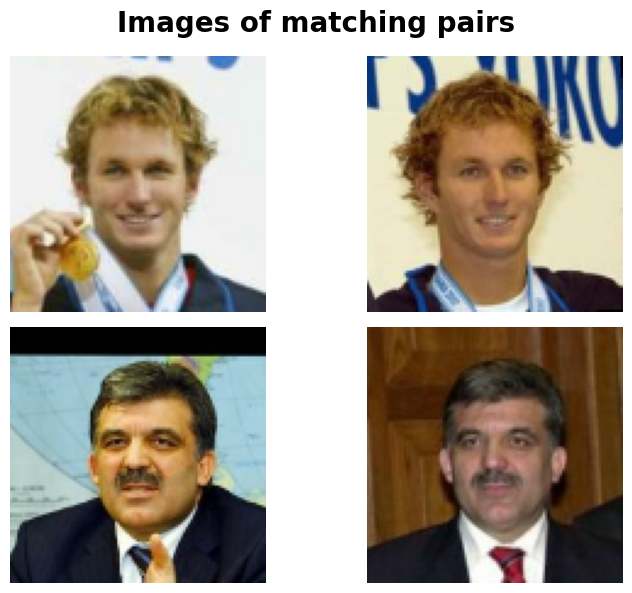

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))

for i , img_pair in enumerate(zip(train_matched_pairs[0], test_matched_pairs[0])):
  for j in range(2):
    axs[j ,i].imshow(img_pair[j])
    axs[j ,i].axis('off')
fig.suptitle("Images of matching pairs",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

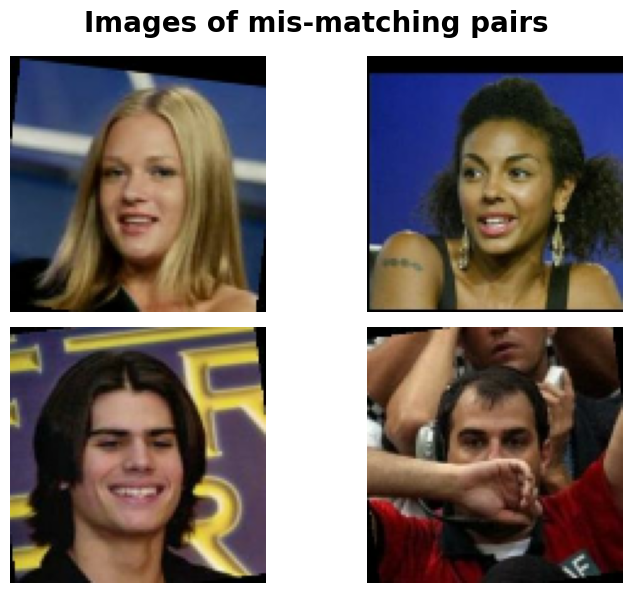

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))

for i , img_pair in enumerate(zip(train_mismatched_pairs[0], test_mismatched_pairs[0])):
  for j in range(2):
    axs[j ,i].imshow(img_pair[j])
    axs[j ,i].axis('off')
fig.suptitle("Images of mis-matching pairs",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_pairs,train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_pairs,test_label))

In [32]:
train_size = int(2000.0/2200.0 * len(train_pairs))
val_size = len(train_pairs) - train_size

In [33]:
samples = train_dataset.as_numpy_iterator()

In [34]:
samp = samples.next()

In [35]:
samp[0][0].shape

(105, 105, 3)

In [36]:
samp[1]

1.0

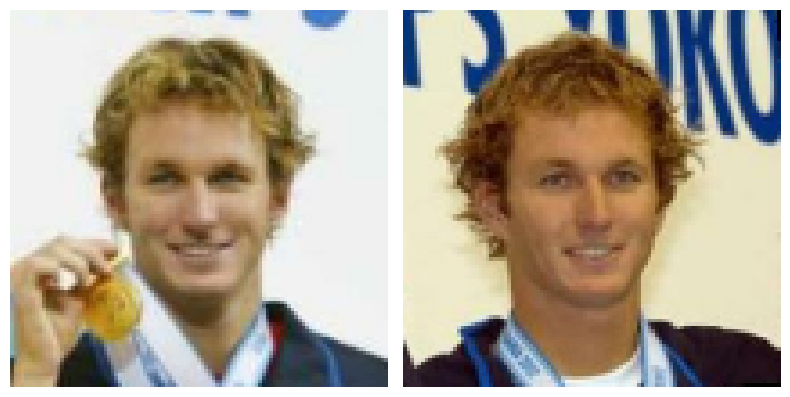

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(8,6))

for i in range(2):
  axs[i].imshow(samp[0][i])
  axs[i].axis('off')
#fig.suptitle("Images of matching pairs",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

In [38]:
def transform(item,label):
  return (item[0],item[1],label)

In [39]:
train_data = train_dataset.map(transform, num_parallel_calls=tf.data.AUTOTUNE)

In [40]:
train_data = train_data.cache()
train_data_ = train_data.shuffle(len(train_data))

train_data = train_data_.take(train_size)
val_data = train_data_.skip(train_size)
print(len(train_data))
print(len(val_data))

train_data = train_data.batch(32)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = val_data.batch(32)
val_data = val_data.prefetch(tf.data.AUTOTUNE)



2000
200


In [41]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [42]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [43]:
len(train_data)

63

In [44]:
len(val_data)

7

In [116]:
test_data = test_dataset.map(transform,num_parallel_calls=tf.data.AUTOTUNE)

In [117]:
test_data = test_data.cache()
test_data = test_data.shuffle(len(test_data))

test_data = test_data.batch(32)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [109]:
len(test_data)

1000

In [48]:
samples = train_data.as_numpy_iterator()
samp = samples.next()

In [49]:
(samp[2].shape)

(32,)

In [50]:
print(samp[0].shape)
print(samp[1].shape)
print(samp[2].shape)

(32, 105, 105, 3)
(32, 105, 105, 3)
(32,)


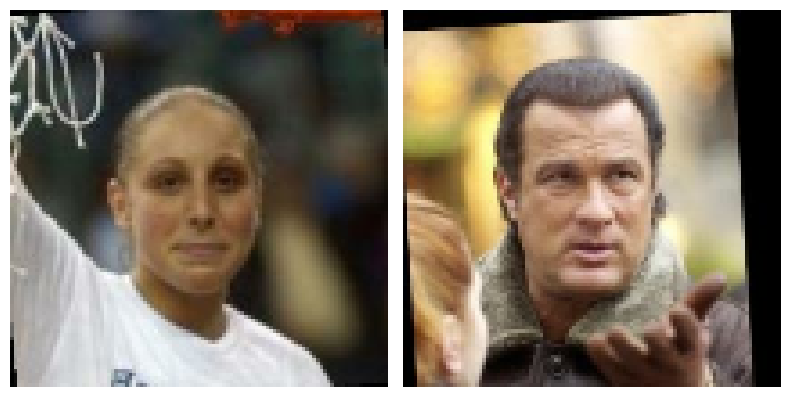

0.0


In [51]:
fig, axs = plt.subplots(1, 2, figsize=(8,6))

for i in range(2):
  axs[i].imshow(samp[i][0])
  axs[i].axis('off')
#fig.suptitle("Images of matching pairs",fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()
print(samp[2][0])

#Build Siamese NEURAL NETWORK

##Embedding Layer

In [52]:
from keras.regularizers import l2

def make_embedding():
  inp = Input(shape=(105,105,3), name = 'input_image')

  #First Block
  c1 = Conv2D(64,(10,10),activation = 'relu',kernel_regularizer=l2(l2=1e-2))(inp)
  m1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(c1)

  #Second Block
  c2 = Conv2D(128,(7,7),activation = 'relu',kernel_regularizer=l2(l2=1e-2))(m1)
  m2 = MaxPooling2D(pool_size = (2,2),padding = 'same')(c2)

  #Third Block
  c3 = Conv2D(128,(4,4),activation = 'relu',kernel_regularizer=l2(l2=1e-2))(m2)
  m3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(c3)

  #Final Block
  c4 = Conv2D(256,(4,4),activation = 'relu',kernel_regularizer=l2(1e-4))(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096,activation = 'sigmoid')(f1)

  return Model(inputs=[inp],outputs=[d1],name = 'embedding' )

In [53]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

##Distance Layer

In [54]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self,input_embedding,validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

##Siamese Model

In [55]:
input_image = Input(name='input_img',shape=(105,105,3))
validation_image = Input(name='validation_img',shape=(105,105,3))

In [56]:
inp_embedding=embedding(input_image)
val_embedding=embedding(validation_image)

In [57]:
L1_siamese_dist_layer = L1Dist()

In [58]:
distances = L1_siamese_dist_layer(inp_embedding, val_embedding)

In [59]:
classifier = Dense(1,activation='sigmoid')(distances)

In [60]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [61]:
siamese_model = Model(inputs=[input_image,validation_image], outputs=classifier, name='Siamese_Neural_Network')

In [62]:
siamese_model.summary()

Model: "Siamese_Neural_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                             

#Training

##Loss function and Optimizer

In [63]:
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.0001
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

In [64]:
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [65]:
samples = train_data.as_numpy_iterator()
sam = samples.next()


In [66]:
print(len(train_data))
print(sam[0].shape)
sam[1].shape
sam[2].shape

63
(32, 105, 105, 3)


(32,)

In [67]:
train_size = len(train_data)
train_batch_size = train_data.as_numpy_iterator().next()[0].shape[0]
val_size = len(val_data)
val_batch_size = val_data.as_numpy_iterator().next()[0].shape[0]

In [68]:
print(train_size , " " , train_batch_size)
print(val_size , " " , val_batch_size)

63   32
7   32


##Build Train Step

In [69]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image

        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss

        loss = binary_cross_loss(y, yhat)
        loss += sum(siamese_model.losses)


    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    train_acc_metric.update_state(y, yhat)
    # Return loss
    return loss
@tf.function
def val_step(batch):
    # Get anchor and positive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]
    yhat = siamese_model(X, training=False)
    loss = binary_cross_loss(y, yhat)

    val_acc_metric.update_state(y, yhat)
    return loss

In [70]:
def train(data,val_data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))

        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss_value = train_step(batch)
            progbar.update(idx+1)
        train_acc = train_acc_metric.result()
        #print(f"Training acc over epoch: {float(train_acc):.4f}")
        # train_acc_metric.reset_states()
        val_loss_array = []
        for batch in (val_data):
          val_loss_array.append(val_step(batch))
        val_loss = np.mean(val_loss_array)
        #print(f"Validation loss: {float(val_loss):.4f}")
        val_acc = val_acc_metric.result()
        print(f"loss: {float(loss_value):.4f} - acc: {float(train_acc):.4f} - val_loss: {float(val_loss):.4f} - val_acc: {float(val_acc):.4f}")
        history['train_loss'].append(float(loss_value))
        history['train_acc'].append(float(train_acc))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        #print(f"Validation acc: {float(val_acc):.4f}")

        #print(f"loss: {float(loss_value):.4f} - acc: {float(train_acc):.4f} - val_loss: {float(val_loss):.4f} - val_acc: {float(val_acc):.4f}")

In [71]:
siamese_model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['binary_accuracy'])

EPOCHS = 50
train(train_data,val_data, EPOCHS)


 Epoch 1/50
63/63 [==============================] - 11s 64ms/step
loss: 1.8959 - acc: 0.4995 - val_loss: 0.6843 - val_acc: 0.4300

 Epoch 2/50
63/63 [==============================] - 3s 41ms/step
loss: 1.3698 - acc: 0.5065 - val_loss: 0.6888 - val_acc: 0.5450

 Epoch 3/50
63/63 [==============================] - 3s 41ms/step
loss: 1.0565 - acc: 0.5385 - val_loss: 0.6661 - val_acc: 0.4550

 Epoch 4/50
63/63 [==============================] - 3s 41ms/step
loss: 0.8607 - acc: 0.5510 - val_loss: 0.6348 - val_acc: 0.6200

 Epoch 5/50
63/63 [==============================] - 3s 41ms/step
loss: 0.7878 - acc: 0.5760 - val_loss: 0.6439 - val_acc: 0.5250

 Epoch 6/50
63/63 [==============================] - 3s 41ms/step
loss: 0.7351 - acc: 0.5915 - val_loss: 0.6659 - val_acc: 0.6150

 Epoch 7/50
63/63 [==============================] - 3s 42ms/step
loss: 0.6847 - acc: 0.6140 - val_loss: 0.6638 - val_acc: 0.6250

 Epoch 8/50
63/63 [==============================] - 3s 41ms/step
loss: 0.7996 - 

#Evaluate Model

##Plotting accuracy and loss graphs

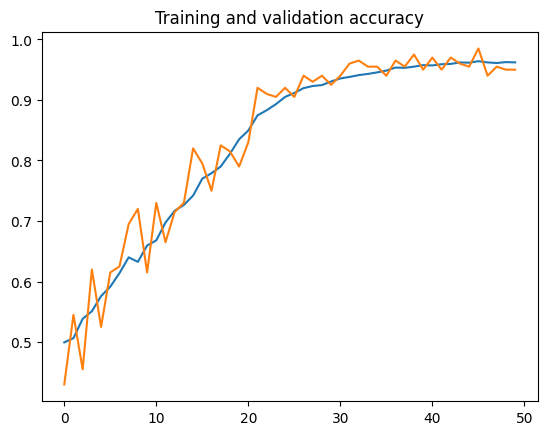

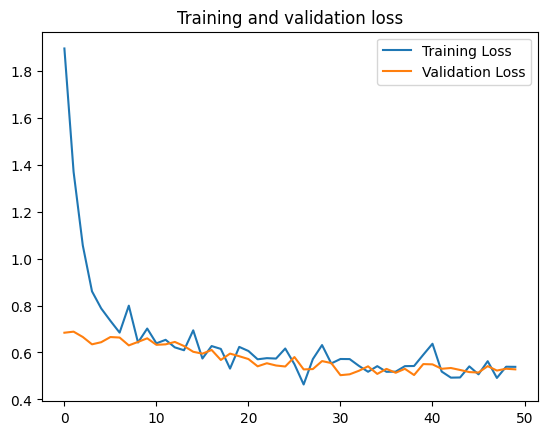

In [72]:
import matplotlib.pyplot as plt
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss =history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [73]:
len(test_data)

32

##Import Metrics

In [111]:
from tensorflow.keras.metrics import Precision, Recall

##Make Predictions

In [162]:
thresh_hold = 0.5
yTrue= []
yHat = []
yHat_= []
for test_input, test_val, y_true in test_data.as_numpy_iterator():
  y_hat = siamese_model.predict([test_input, test_val])
  yHat_ = np.concatenate((yHat_,y_hat[:,0]),axis=0)
  y_hat = np.array([1 if prediction >= 0.5 else 0 for prediction in y_hat ]).T
  yTrue = np.concatenate((yTrue,y_true),axis=0)
  yHat = np.concatenate((yHat,y_hat),axis=0)




1/1 [==============================] - 0s 22ms/step


##Calculate Metrics

In [163]:

# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(yTrue, yHat)

# Return Recall Result
m.result().numpy()

0.604

In [164]:

# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(yTrue, yHat)

# Return Recall Result
m.result().numpy()

0.6522678

In [165]:

m = tf.keras.metrics.Accuracy()

# Calculating the recall value
m.update_state(yTrue, yHat)

# Return Recall Result
m.result().numpy()

0.641

##Tuning threshHold

In [169]:
thresh_hold = 0.2
step = 0.01
best_acc = 0
best_thresh_hold = 0
while(thresh_hold <= 0.8):
  y_hat_ = np.array([1 if prediction >= thresh_hold else 0 for prediction in yHat_ ]).T
  m = tf.keras.metrics.Accuracy()
  m.update_state(yTrue, y_hat_)
  print(f"THRESH_HOLD: {thresh_hold} - acc : {m.result().numpy()}")
  if m.result().numpy() > best_acc:
    best_acc = m.result().numpy()
    best_thresh_hold = thresh_hold
  thresh_hold += step

THRESH_HOLD: 0.2 - acc : 0.6340000033378601
THRESH_HOLD: 0.21000000000000002 - acc : 0.6330000162124634
THRESH_HOLD: 0.22000000000000003 - acc : 0.6380000114440918
THRESH_HOLD: 0.23000000000000004 - acc : 0.6380000114440918
THRESH_HOLD: 0.24000000000000005 - acc : 0.6389999985694885
THRESH_HOLD: 0.25000000000000006 - acc : 0.6389999985694885
THRESH_HOLD: 0.26000000000000006 - acc : 0.6399999856948853
THRESH_HOLD: 0.2700000000000001 - acc : 0.6399999856948853
THRESH_HOLD: 0.2800000000000001 - acc : 0.6370000243186951
THRESH_HOLD: 0.2900000000000001 - acc : 0.6370000243186951
THRESH_HOLD: 0.3000000000000001 - acc : 0.6380000114440918
THRESH_HOLD: 0.3100000000000001 - acc : 0.6389999985694885
THRESH_HOLD: 0.3200000000000001 - acc : 0.6420000195503235
THRESH_HOLD: 0.3300000000000001 - acc : 0.6389999985694885
THRESH_HOLD: 0.34000000000000014 - acc : 0.6389999985694885
THRESH_HOLD: 0.35000000000000014 - acc : 0.6380000114440918
THRESH_HOLD: 0.36000000000000015 - acc : 0.6399999856948853
THR

In [170]:
print(f"Best thresh_hold: {best_thresh_hold} - acc : {best_acc}")

Best thresh_hold: 0.48000000000000026 - acc : 0.6439999938011169
